In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as date
import seaborn as sns

sns.set_context('talk')

In [3]:
data_crime_raw = pd.read_csv('.\\NYPD_Complaint_Data_Historic.csv',
                             usecols=['CMPLNT_FR_DT', 'OFNS_DESC', 'LAW_CAT_CD', 'Latitude', 'Longitude', 'BORO_NM'],
                             dtype={'OFNS_DESC':'category', 'LAW_CAT_CD':'category', 'BORO_NM':'category',
                                    'Latitude':float, 'Longitude':float})

data_crime_raw['CMPLNT_FR_DT'] = pd.to_datetime(data_crime_raw['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')

In [4]:
data_311_raw = pd.read_csv('.\\311_Service_Requests_from_2010_to_Present.csv',
                           usecols=['Created Date', 'Complaint Type', 'Descriptor', 'Latitude', 'Longitude', 'Borough'],
                           dtype={'Complaint Type':'category', 'Descriptor':'category', 'Borough':'category',
                                  'Latitude':float, 'Longitude':float})

data_311_raw['created_date'] = pd.to_datetime(data_311_raw['Created Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [5]:
data_crime = data_crime_raw[data_crime_raw.CMPLNT_FR_DT > pd.to_datetime(dt.date(2010,1,1))].dropna()
data_311 = data_311_raw[data_311_raw.created_date < pd.to_datetime(dt.date(2016,1,1))].dropna()

In [6]:
minlat = data_crime.Latitude.min()
maxlat = data_crime.Latitude.max()
minlon = data_crime.Longitude.min()
maxlon = data_crime.Longitude.max()

latrange = np.arange(minlat, maxlat+0.02, 0.02)
lonrange = np.arange(minlon, maxlon+0.02, 0.02)

In [7]:
data_crime = data_crime[data_crime.LAW_CAT_CD != 'VIOLATION']

In [8]:
boros = data_crime['BORO_NM'].cat.categories.tolist()
d_c_by_boro = {}
max_crime_loc = {}
min_crime_loc = {}

for boro in boros:
    d_c_by_boro[boro] = data_crime[data_crime['BORO_NM']==boro].groupby(
        by=[pd.cut(data_crime[data_crime['BORO_NM']==boro]['Latitude'], latrange),
        pd.cut(data_crime[data_crime['BORO_NM']==boro]['Longitude'], lonrange),
        pd.TimeGrouper(key='CMPLNT_FR_DT',freq='M')])
    
    max_crime_loc[boro] = d_c_by_boro[boro].size().unstack().mean(axis=1).argmax()
    min_crime_loc[boro] = d_c_by_boro[boro].size().unstack().mean(axis=1).argmin()

In [9]:
min_crime_loc

{'BRONX': (Interval(40.658999999999999, 40.679000000000002, closed='right'),
  Interval(-74.015000000000001, -73.995000000000005, closed='right')),
 'BROOKLYN': (Interval(40.619, 40.639000000000003, closed='right'),
  Interval(-74.155000000000001, -74.135000000000005, closed='right')),
 'MANHATTAN': (Interval(40.639000000000003, 40.658999999999999, closed='right'),
  Interval(-74.015000000000001, -73.995000000000005, closed='right')),
 'QUEENS': (Interval(40.579000000000001, 40.598999999999997, closed='right'),
  Interval(-73.875, -73.855000000000004, closed='right')),
 'STATEN ISLAND': (Interval(40.598999999999997, 40.619, closed='right'),
  Interval(-74.215000000000003, -74.194999999999993, closed='right'))}

In [10]:
d_311_grouped = data_311.groupby(
    by=[pd.cut(data_311['Latitude'], latrange),
        pd.cut(data_311['Longitude'], lonrange),
        pd.TimeGrouper(key='created_date',freq='M')])

d_c_grouped = data_crime.groupby(
    by=[pd.cut(data_crime['Latitude'], latrange),
    pd.cut(data_crime['Longitude'], lonrange),
    pd.TimeGrouper(key='CMPLNT_FR_DT',freq='M')])

d_311_largest = {}
data = {}

complaint_311_count = data_311['Complaint Type'].value_counts()

for boro in boros:
    data[boro] = d_c_grouped.size().loc[max_crime_loc[boro]].to_frame('total_crimes').merge(
        d_311_grouped['Complaint Type'].value_counts().loc[max_crime_loc[boro]].unstack().fillna(0),
        left_index=True, right_index=True, how='inner')

In [11]:
d_311_grouped = data_311.groupby(
    by=['Borough'])

d_c_grouped = data_crime.groupby(
    by=['BORO_NM'])

data = d_311_grouped.size().to_frame('311').merge(d_c_grouped.size().to_frame('crime'), left_index=True, right_index=True)

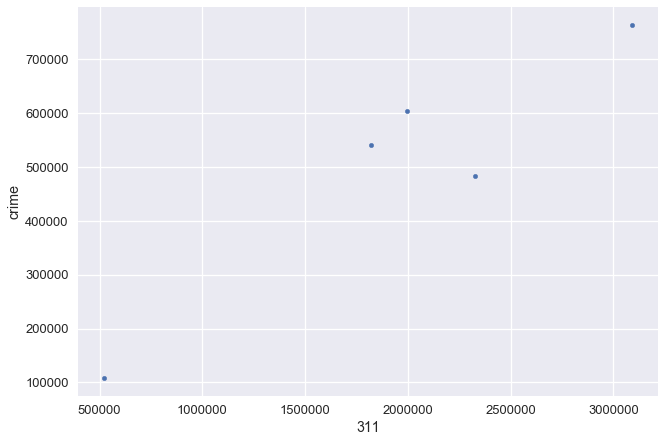

In [12]:
plt.close('all')
data.plot(kind='scatter', x='311', y='crime')
plt.show()

In [13]:
d_311_grouped = data_311.groupby(
    by=[pd.cut(data_311['Latitude'], latrange),
        pd.cut(data_311['Longitude'], lonrange)])

d_c_grouped = data_crime.groupby(
    by=[pd.cut(data_crime['Latitude'], latrange),
    pd.cut(data_crime['Longitude'], lonrange)])

data = d_311_grouped.size().to_frame('311').merge(d_c_grouped.size().to_frame('crime'), left_index=True, right_index=True)

In [36]:
data_311 = np.array(data['311'].apply(int))
data_crime = np.array(data['crime'].apply(int))
plt.close('all')
# data.plot(kind='scatter', x='311', y='crime')
sns.regplot(x=data_311, y=data_crime)
plt.suptitle('311 v total crime 2010-2016\ngrouped by location')
plt.xlabel('Total 311 complaints')
plt.ylabel('Total reported crime')
plt.savefig('311vcrime.png', format='png')
# plt.show()